# **Measuring Similarity**

Measure of similarity can be qualitative and/or quantitative. In qualitative, the assessment is done against subjective criteria such as theme, sentiment, overall meaning, etc. In the quantitative, numerical parameters such as length of the document, number of keywords, common words, etc. are compared. The process is carried out in two steps, as mentioned below:

> * Vectorization: Transform the documents into a vector of numbers. Following are some of the popular numbers(measures): TF (Term Frequency), IDF (Inverse Document Frequency) and TF*IDF.
> * Distance Computation: Compute the cosine similarity between the document vector. As we know, the cosine (dot product) of the same vectors is 1, dissimilar/perpendicular ones are 0, so the dot product of two vector-documents is some value between 0 and 1, which is the measure of similarity amongst the

Test-case used in this post is of finding similarity between two news reports [^1, ^2] of a recent bus accident (Sources mentioned in the References). Programming language ‘Python’ and its Natural Language Toolkit library ‘nltk’ [^3] are primarily used here. The similarity analysis is done in steps as mentioned below.

## **Documents Pre-Processing**

The news reports contain many things which are not core (or irrelevant) for text analysis exercise such as finding similarity. So, they are pre-processed by converting their words into lower case and removing the ‘stopwords’, like ‘the’, ‘should’, etc.

In [ ]:
!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn nltk gensim --user -q --no-warn-script-location


In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords_en = stopwords.words("english")


def preprocessing(raw):
  wordlist = nltk.word_tokenize(raw)
  text = [w.lower() for w in wordlist if w not in stopwords_en]
  return text

f1 = open('buscrash_foxnews.txt', 'r', encoding ='utf8')
text1 = preprocessing(f1.read())

f2 = open('buscrash_reuters.txt', 'r', encoding='utf8')
text2 = preprocessing(f2.read())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Vectorization**

Characterize each text as a vector. Each text has some common and some uncommon words compared to each other. To account for all possibilities, a word set is formed which consists of words from both the documents. There are various methods by which words can be vectorised, meaning, converted to vectors (array of numbers). A few of the prominent ones are explained below.

### **Frequency Count Method**

A simplest way to create the vectors is to count number of times each word from the common word set, occurs in individual document.FreqDist counts the number of occurrence of a word in the given text. So, in the above code snippet text1_count_dict has word-count pairs of all the words from the common word_set, along with their individual counts. Following table shows few words with their frequencies:

In [4]:
from nltk.probability import FreqDist

word_set = set(text1).union(set(text2))

freqd_text1 = FreqDist(text1)
text1_count_dict = dict.fromkeys(word_set, 0)
for word in text1:
  text1_count_dict[word] = freqd_text1[word]

freqd_text2 = FreqDist(text2)
text2_count_dict = dict.fromkeys(word_set, 0)
for word in text2:
  text2_count_dict[word] = freqd_text2[word]

FreqDist counts the number of occurrence of a word in the given text. So, in the above code snippet text1_count_dict has word-count pairs of all the words from the common word_set, along with their individual counts. Following table shows few words with their frequencies:

FreqDist counts the number of occurrence of a word in the given text. So, in the above code snippet text1_count_dict has word-count pairs of all the words from the common word_set, along with their individual counts. Following table shows few words with their frequencies: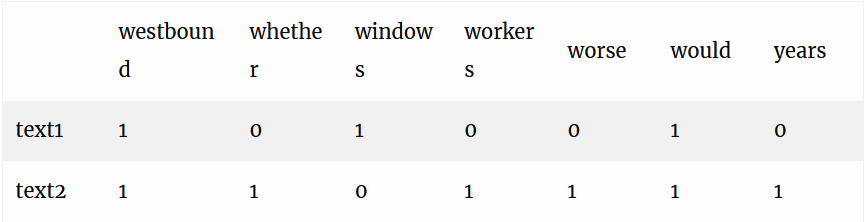

### **TF-IDF Method**

TF is document specific. It is a way to score the importance of words (or “terms”) in a document based on how frequently they appear. If a word appears frequently in a document, it’s important, it gets a high score. Although it is easy to compute, it is ambiguous (‘green’ the colour and ‘green’ the person’s name is not differentiated).

In [5]:
freqd_text1 = FreqDist(text1)
text1_length = len(text1)
text1_tf_dict = dict.fromkeys(word_set, 0)
for word in text1:
  text1_tf_dict[word] = freqd_text1[word]/ text1_length

freqd_text2 = FreqDist(text2)
text2_length = len(text2)
text2_tf_dict = dict.fromkeys(word_set, 0)
for word in text2:
  text2_tf_dict[word] = freqd_text2[word]/ text2_length

IDF is for the whole collection. It is a way to score how many times a word occurs across multiple documents. If a word appears in many documents, it’s not a unique identifier, thus gets a lower score.


In [6]:
#IDF Calculations
text12_idf_dict = dict.fromkeys(word_set, 0)
text12_length = 2 #2 documents
for word in text12_idf_dict.keys():
  if word in text1:
    text12_idf_dict[word]+=1
  if word in text2:
    text12_idf_dict[word]+=1

TFIDF of a word = (TF of the word) * (IDF of the word)

In [8]:
#TF-IDF Calculations
text1_tfidf_dict = dict.fromkeys(word_set, 0)
for word in text1:
  text1_tfidf_dict[word] = (text1_tf_dict[word]) * (text12_idf_dict[word])

text2_tfidf_dict = dict.fromkeys(word_set, 0)
for word in text2:
  text2_tfidf_dict[word] = (text2_tf_dict[word]*(text12_idf_dict[word]))

### **Word Embedding Method**

Of-late Word embedding are being used to vectorise words, and using that the whole documents. Google’s Word2Vec and Doc2Vec available from Python’s genism library [^6] can be used to vectorise the news reports and then find similarity between them.

In [14]:
from gensim.models.doc2vec import TaggedDocument
import gensim
taggeddocs = []
doc1 = TaggedDocument(words=text1, tags =[u'NEWS_1'])
taggeddocs.append(doc1)

doc2 = TaggedDocument(words=text2, tags = [u'NEWS_2'])
taggeddocs.append(doc2)

#build the model
model = gensim.models.Doc2Vec(taggeddocs, dm=0, alpha=0.25, size=20, min_alpha=0.025, min_count = 0)

#training
for epoch in range(80):
  if epoch%20==0:
    print('Now Training Epoch %s'% epoch)
  model.train(taggeddocs, epochs=model.iter, total_examples=model.corpus_count)
  model.alpha -=0.002 #decrease the learning rate
  model.min_alpha = model.alpha #fix the learning rate, no decay

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Now Training Epoch 0
Now Training Epoch 20
Now Training Epoch 40
Now Training Epoch 60


Once the words in the text are vectorised, the similarity score between them is nothing but the ‘distance’ between them.

## **Distance computation**

Following are the steps to compute the similarity of two texts using TF-IDF Method. It is computed using the dot product of given vectors v1 and v2.

In [15]:
#Compute cosine distance
v1 = list(text1_tfidf_dict.values())
v2 = list(text2_tfidf_dict.values())

similarity = 1-nltk.cluster.cosine_distance(v1, v2)
print("Similarity Index: {:4.2f}%".format(similarity*100))

Similarity Index: 90.09%



For the given two news items the similarity score came to about 90.09%. 

In [16]:
similarity = model.n_similarity(text1, text2)
print("Similarity Index: {:4.2f}%".format(similarity*100))

Similarity Index: 88.95%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  """Entry point for launching an IPython kernel.


In case of Word Embedding method, the Doc2Vec model itself can compute similarity of given texts. For the given two news items the similarity score came to about 88.95%.

# **Read more articles on:**


> * [NLP Case Study of Documents Similarity](https://analyticsindiamag.com/nlp-case-study-identify/)

> * [Review Classification](https://analyticsindiamag.com/step-by-step-guide-to-reviews-classification-using-svc-naive-bayes-random-forest/)

> * [Multi Class Text Classification](https://analyticsindiamag.com/multi-class-text-classification-in-pytorch-using-torchtext/)

> * [Text Classification](https://analyticsindiamag.com/how-to-solve-your-first-ever-nlp-classification-challenge/)

> * [Word Frequency](https://analyticsindiamag.com/using-natural-language-processing-to-check-word-frequency-in-the-adventure-of-sherlock-holmes/)

> * [Vocabulary Builder](https://analyticsindiamag.com/how-to-create-a-vocabulary-builder-for-nlp-tasks/)
